In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.dirname(os.path.dirname(os.path.join(os.getcwd())))))

import json
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from data_utils.utils import keep_existing_photos, downsample_group
from data_utils.dataset import MultimodalDataset, train_transform, val_transform
from model.fusion_model import FusionModel
from model.utils import (
    get_device,
    train_model_single_epoch_multimodal,
    validate_model_single_epoch_multimodal,
    save_checkpoint,
    evaluate_model_multimodal,
    plot_history,
)

/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data preprocessing

In [2]:
base_dir = "../../"

business_df = pd.read_json(f'{base_dir}data/yelp_dataset/yelp_academic_dataset_business.json', lines=True)
photos_df = pd.read_json(f'{base_dir}data/yelp_photos/photos.json', lines=True)
top_reviews_per_restaurant = pd.read_csv(f'{base_dir}data/yelp_dataset/top_reviews_per_restaurant_with_summary.csv')

photo_dir = f"{base_dir}data/yelp_photos/resized_photos"
photos_df = keep_existing_photos(photos_df, photo_dir)

photos_df = photos_df[photos_df['label'] == 'food'].copy()

categories_df = business_df[['business_id', 'attributes']].copy()
photos_df = photos_df.merge(categories_df, on="business_id", how="left")

photos_df = photos_df[photos_df['attributes'].notna()]
photos_df['price_range'] = photos_df['attributes'].apply(lambda x: x.get('RestaurantsPriceRange2'))

photos_df['price_range'] = photos_df['price_range'].astype(int)
photos_df['price_range'] = photos_df['price_range'].replace(4, 3)

food_with_reviews_df = photos_df.merge(top_reviews_per_restaurant, on="business_id", how="left")
food_with_reviews_df.price_range.value_counts()

Checking images: 100%|██████████| 200100/200100 [00:05<00:00, 37722.64it/s]


price_range
2    63103
1    25719
3     8107
Name: count, dtype: int64

In [3]:
len(food_with_reviews_df)

96929

In [4]:
price_3_num = (photos_df.price_range == 3).sum()

food_df = food_with_reviews_df.groupby('price_range', group_keys=False).apply(
    lambda x: downsample_group(x, price_3_num) if x.name in [1, 2] else x  # Only downsample for price_range 1 and 2
)

food_df['price_range'] = food_df['price_range'] - 1

/var/folders/6n/sm2tfzkn2hjd8cpfn_256ph00000gp/T/ipykernel_30434/3162148630.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  food_df = food_with_reviews_df.groupby('price_range', group_keys=False).apply(


In [5]:
with open(f'{base_dir}data/multimodal_split_ids.json') as f:
    ids_dict = json.load(f)

train_ids = ids_dict['train_ids']
val_ids = ids_dict['val_ids']
test_ids = ids_dict['test_ids']

train_df = food_df[food_df.business_id.isin(train_ids)]
val_df = food_df[food_df.business_id.isin(val_ids)]
test_df = food_df[food_df.business_id.isin(test_ids)]

In [6]:
label = 'price_range'

train_dataset = MultimodalDataset(train_df, photo_dir, label)
val_dataset = MultimodalDataset(val_df, photo_dir, label)
test_dataset = MultimodalDataset(test_df, photo_dir, label)

train_dataset.transform = train_transform
val_dataset.transform = val_transform
test_dataset.transform = val_transform

batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

for batch in train_loader:
    print("Images shape:", batch['image'].shape)  
    print("Input_ids shape:", batch['input_ids'].shape)
    print("Labels shape:", batch['label'].shape)
    break

Images shape: torch.Size([64, 3, 224, 224])
Input_ids shape: torch.Size([64, 128])
Labels shape: torch.Size([64])


### Model training

In [7]:
num_classes = 3
device = get_device()

model = FusionModel(num_classes=num_classes)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
scaler = torch.amp.GradScaler("cuda")
grad_clip = 1
ckpt_dir = "checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos"

history = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, device, scaler, grad_clip, history, ckpt_dir, num_epochs=10):
    model.train()

    for epoch in range(1, num_epochs+1):
        train_loss, train_accuracy = train_model_single_epoch_multimodal(
            model, train_loader, criterion, optimizer, device, scaler, grad_clip
        )
        val_loss, val_accuracy = validate_model_single_epoch_multimodal(model, val_loader, criterion, device)

        print(
            f"[Epoch {epoch}/{num_epochs}]",
            f"Train Loss: {train_loss:.4f} | " f"Train Accuracy: {train_accuracy:.4f}",
            f"Val Loss: {val_loss:.4f} | " f"Val Accuracy: {val_accuracy:.4f}"
        )

        history["train_loss"].append(train_loss)
        history["train_accuracy"].append(train_accuracy)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)

        save_checkpoint(epoch, model, optimizer, history, ckpt_dir)

/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/ericxia/Library/Caches/pypoetry/virtualenvs/food-classification-nES7ttkF-py3.10/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  

In [25]:
num_epochs = 20
train_model(model, train_loader, val_loader, criterion, optimizer, device, scaler, grad_clip, history, ckpt_dir, num_epochs=num_epochs)

Training: 100%|██████████| 345/345 [04:30<00:00,  1.28it/s, loss=0.847]


[Epoch 1/20] Train Loss: 0.9264 | Train Accuracy: 0.5405 Val Loss: 0.8274 | Val Accuracy: 0.5945
Model checkpoint saved at checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos/ckpt_1


Training: 100%|██████████| 345/345 [04:26<00:00,  1.29it/s, loss=0.821]


[Epoch 2/20] Train Loss: 0.8510 | Train Accuracy: 0.5950 Val Loss: 0.7712 | Val Accuracy: 0.6424
Model checkpoint saved at checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos/ckpt_2


Training: 100%|██████████| 345/345 [10:29<00:00,  1.83s/it, loss=0.919]


[Epoch 3/20] Train Loss: 0.8239 | Train Accuracy: 0.6098 Val Loss: 0.7825 | Val Accuracy: 0.6175
Model checkpoint saved at checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos/ckpt_3


Training: 100%|██████████| 345/345 [09:02<00:00,  1.57s/it, loss=0.877]


[Epoch 4/20] Train Loss: 0.8130 | Train Accuracy: 0.6158 Val Loss: 0.8286 | Val Accuracy: 0.5982
Model checkpoint saved at checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos/ckpt_4


Training: 100%|██████████| 345/345 [09:06<00:00,  1.58s/it, loss=0.769]


[Epoch 5/20] Train Loss: 0.8064 | Train Accuracy: 0.6239 Val Loss: 0.7667 | Val Accuracy: 0.6286
Model checkpoint saved at checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos/ckpt_5


Training: 100%|██████████| 345/345 [08:50<00:00,  1.54s/it, loss=0.824]


[Epoch 6/20] Train Loss: 0.7901 | Train Accuracy: 0.6304 Val Loss: 0.8092 | Val Accuracy: 0.5972
Model checkpoint saved at checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos/ckpt_6


Training: 100%|██████████| 345/345 [07:55<00:00,  1.38s/it, loss=0.784]


[Epoch 7/20] Train Loss: 0.7849 | Train Accuracy: 0.6303 Val Loss: 0.8527 | Val Accuracy: 0.5982
Model checkpoint saved at checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos/ckpt_7


Training: 100%|██████████| 345/345 [04:47<00:00,  1.20it/s, loss=0.886]


[Epoch 8/20] Train Loss: 0.7885 | Train Accuracy: 0.6326 Val Loss: 0.7959 | Val Accuracy: 0.6221
Model checkpoint saved at checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos/ckpt_8


Training: 100%|██████████| 345/345 [08:49<00:00,  1.53s/it, loss=0.835]


[Epoch 9/20] Train Loss: 0.7790 | Train Accuracy: 0.6377 Val Loss: 0.8430 | Val Accuracy: 0.6129
Model checkpoint saved at checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos/ckpt_9


Training: 100%|██████████| 345/345 [09:02<00:00,  1.57s/it, loss=0.905]


[Epoch 10/20] Train Loss: 0.7725 | Train Accuracy: 0.6409 Val Loss: 0.8342 | Val Accuracy: 0.6120
Model checkpoint saved at checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos/ckpt_10


Training: 100%|██████████| 345/345 [09:03<00:00,  1.57s/it, loss=0.994]


[Epoch 11/20] Train Loss: 0.7693 | Train Accuracy: 0.6424 Val Loss: 0.8690 | Val Accuracy: 0.5816
Model checkpoint saved at checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos/ckpt_11


Training: 100%|██████████| 345/345 [08:40<00:00,  1.51s/it, loss=0.865]


[Epoch 12/20] Train Loss: 0.7606 | Train Accuracy: 0.6481 Val Loss: 0.8841 | Val Accuracy: 0.5862
Model checkpoint saved at checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos/ckpt_12


Training: 100%|██████████| 345/345 [07:41<00:00,  1.34s/it, loss=0.962]


[Epoch 13/20] Train Loss: 0.7614 | Train Accuracy: 0.6436 Val Loss: 0.8015 | Val Accuracy: 0.6175
Model checkpoint saved at checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos/ckpt_13


Training: 100%|██████████| 345/345 [06:29<00:00,  1.13s/it, loss=0.53] 


[Epoch 14/20] Train Loss: 0.7516 | Train Accuracy: 0.6507 Val Loss: 0.8099 | Val Accuracy: 0.6276
Model checkpoint saved at checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos/ckpt_14


Training: 100%|██████████| 345/345 [08:47<00:00,  1.53s/it, loss=0.718]


[Epoch 15/20] Train Loss: 0.7472 | Train Accuracy: 0.6541 Val Loss: 0.8037 | Val Accuracy: 0.6221
Model checkpoint saved at checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos/ckpt_15


Training: 100%|██████████| 345/345 [09:04<00:00,  1.58s/it, loss=0.742]


[Epoch 16/20] Train Loss: 0.7444 | Train Accuracy: 0.6564 Val Loss: 0.8008 | Val Accuracy: 0.6037
Model checkpoint saved at checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos/ckpt_16


Training: 100%|██████████| 345/345 [08:51<00:00,  1.54s/it, loss=0.855]


[Epoch 17/20] Train Loss: 0.7460 | Train Accuracy: 0.6533 Val Loss: 0.8685 | Val Accuracy: 0.6332
Model checkpoint saved at checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos/ckpt_17


Training: 100%|██████████| 345/345 [07:58<00:00,  1.39s/it, loss=0.863]


[Epoch 18/20] Train Loss: 0.7402 | Train Accuracy: 0.6565 Val Loss: 0.7759 | Val Accuracy: 0.6313
Model checkpoint saved at checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos/ckpt_18


Training: 100%|██████████| 345/345 [06:49<00:00,  1.19s/it, loss=0.717]


[Epoch 19/20] Train Loss: 0.7315 | Train Accuracy: 0.6607 Val Loss: 0.7966 | Val Accuracy: 0.6221
Model checkpoint saved at checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos/ckpt_19


Training: 100%|██████████| 345/345 [06:56<00:00,  1.21s/it, loss=0.797]


[Epoch 20/20] Train Loss: 0.7295 | Train Accuracy: 0.6589 Val Loss: 0.7984 | Val Accuracy: 0.6157
Model checkpoint saved at checkpoints/price_model_multimodal_multiclass_unique_restaurants_duplicate_photos/ckpt_20


### Model evaluation

In [8]:
ckpt = torch.load(f"{base_dir}saved_models/price_multiclass_multimodal/ckpt_best", map_location="cpu")
model = FusionModel(num_classes=num_classes)
model.load_state_dict(ckpt['model_state_dict'])
model.to(device)
model.eval()

FusionModel(
  (image_encoder): ResNetFeatureExtractor(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [18]:
torch.save({'model_state_dict': ckpt['model_state_dict']}, 'best_model.pth')

In [9]:
evaluate_model_multimodal(model, train_loader, device, ['0', '1', '2'])

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.74      0.70      2986
           1       0.57      0.60      0.59      3995
           2       0.87      0.80      0.84      7326

    accuracy                           0.73     14307
   macro avg       0.70      0.71      0.71     14307
weighted avg       0.74      0.73      0.74     14307



In [10]:
evaluate_model_multimodal(model, test_loader, device, ['0', '1', '2'])

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.70      0.66       171
           1       0.64      0.64      0.64       264
           2       0.89      0.86      0.88       414

    accuracy                           0.76       849
   macro avg       0.72      0.73      0.73       849
weighted avg       0.76      0.76      0.76       849



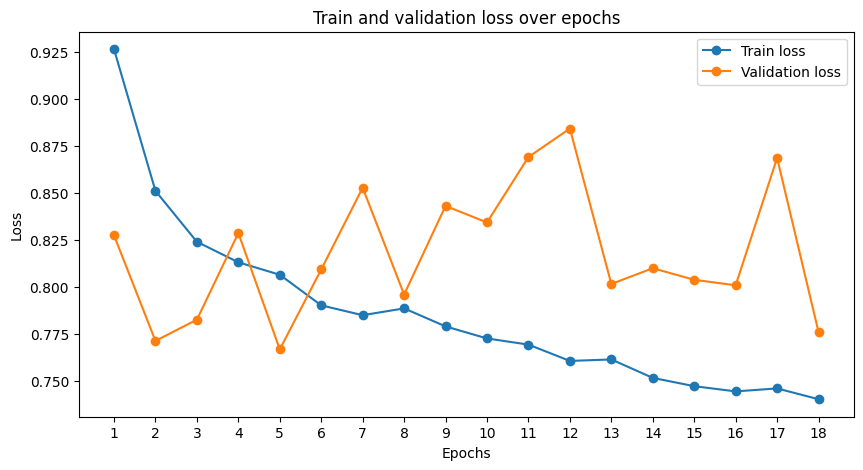

In [9]:
history = ckpt['history']
plot_history(history, 'loss')

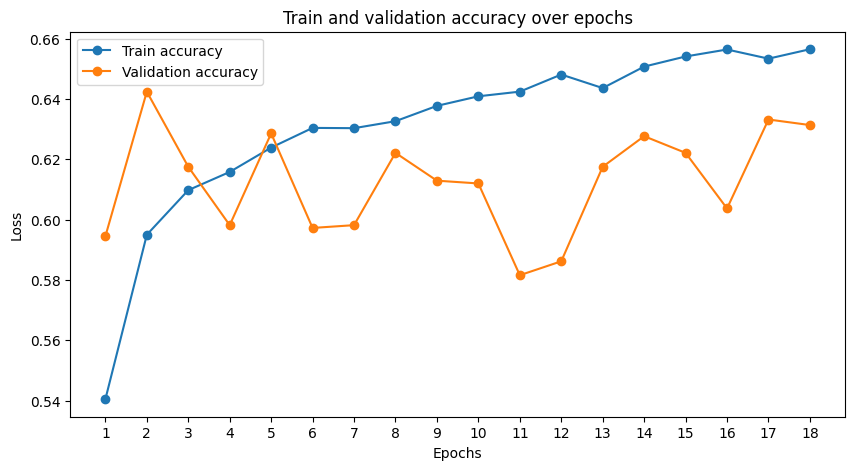

In [10]:
plot_history(history, 'accuracy')